In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

In [2]:
# Step 1: Load Real-Time Sensor Data from CSV
file_path = "/content/Car_Monitoring_Data.csv"  # Replace with the path to your local CSV file
sensor_data = pd.read_csv(file_path)


In [3]:
# Ensure the necessary columns are present
required_columns = ['Timestamp', 'Oxygen', 'CO2', 'CO', 'Methane', 'Temperature',
                    'Car Started', 'AC On', 'Person Inside', 'Car Locked', 'Alarm Triggered']
if not all(col in sensor_data.columns for col in required_columns):
    raise ValueError(f"The dataset must contain the following columns: {required_columns}")

In [4]:
# Convert the Timestamp column to datetime
sensor_data['Timestamp'] = pd.to_datetime(sensor_data['Timestamp'])

<ipython-input-4-b50a837f1e4e>:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sensor_data['Timestamp'] = pd.to_datetime(sensor_data['Timestamp'])


In [5]:
# Define hypoxia-like labeling based on oxygen level thresholds (Example: Oxygen < 18% indicates an issue)
def label_oxygen_issue(row):
    return 1 if row['Oxygen'] < 18 else 0

sensor_data['Oxygen_Issue'] = sensor_data.apply(label_oxygen_issue, axis=1)

In [6]:
# Step 2: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sensor_data[['Oxygen', 'CO2', 'CO', 'Methane', 'Temperature']])

In [7]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(sensor_data['Oxygen_Issue'].values[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



In [8]:
# Step 3: Build Hybrid Model (LSTM + GAN)
# Generator Model
def build_generator(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(X_train.shape[1] * X_train.shape[2], activation='tanh')(x)
    generator_output = x
    generator = Model(inputs=input_layer, outputs=generator_output)
    return generator

In [9]:
# Discriminator Model
def build_discriminator(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    discriminator_output = x
    discriminator = Model(inputs=input_layer, outputs=discriminator_output)
    return discriminator


In [10]:
# LSTM Model for Classification
def build_lstm_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    lstm_branch = LSTM(50, return_sequences=True)(input_layer)
    lstm_branch = LSTM(50)(lstm_branch)
    output_layer = Dense(1, activation='sigmoid')(lstm_branch)
    lstm_model = Model(inputs=input_layer, outputs=output_layer)
    return lstm_model

In [18]:
# Hybrid Model
generator = build_generator(input_dim=100)
discriminator = build_discriminator(input_shape=(X_train.shape[1] * X_train.shape[2],))
lstm_classifier = build_lstm_classifier(input_shape=(X_train.shape[1], X_train.shape[2]))

# Compile the GAN
input_noise = Input(shape=(100,))
fake_data = generator(input_noise)
discriminator.trainable = False
validity = discriminator(fake_data)
combined_gan = Model(inputs=input_noise, outputs=validity)
combined_gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
lstm_classifier.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/63
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9953 - loss: 0.0150 - val_accuracy: 0.6186 - val_loss: 2.0269
Epoch 2/63
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9975 - loss: 0.0182 - val_accuracy: 0.6701 - val_loss: 1.8762
Epoch 3/63
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9987 - loss: 0.0111 - val_accuracy: 0.6392 - val_loss: 2.0729
Epoch 4/63
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9988 - loss: 0.0070 - val_accuracy: 0.6546 - val_loss: 2.0609
Epoch 5/63
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9991 - loss: 0.0075 - val_accuracy: 0.5515 - val_loss: 2.4424
Epoch 6/63
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9996 - loss: 0.0046 - val_accuracy: 0.5103 - val_loss: 2.9555
Epoch 7/63
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9939 - loss: 0.0255 - val_accuracy: 0.7784 - val_loss: 1.1305
Epoch 8/63
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9953 - loss: 0.0143 - val_accuracy: 0.8144 - v

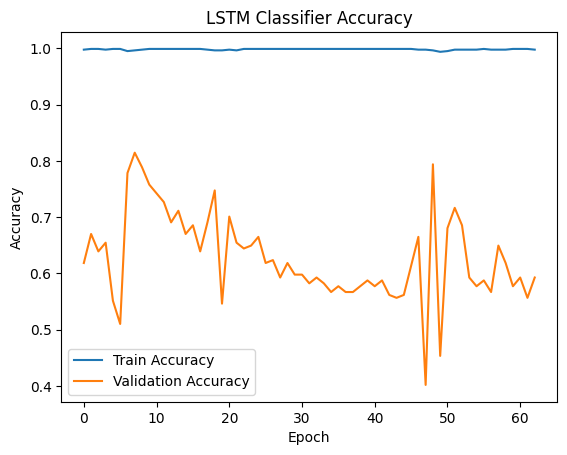

In [38]:
# Train LSTM Classifier
history = lstm_classifier.fit(X_train, y_train, epochs=63, batch_size=batch_size, validation_data=(X_test, y_test))

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [39]:
# Step 5: Real-Time Monitoring and Prediction
def real_time_prediction(new_data, model, scaler, sequence_length=30):
    # Ensure new data is scaled
    new_data_scaled = scaler.transform(new_data)
    X_input = new_data_scaled[-sequence_length:].reshape(1, sequence_length, -1)
    prediction = model.predict(X_input)
    oxygen_level = new_data[-1, 0]  # Last oxygen level in the sequence
    persons_inside = new_data[-1, 2]  # Assuming Person Inside column index in scaled data

    if prediction > 0.5:
        status = f"Warning: Oxygen Issue Detected! Oxygen Level: {oxygen_level:.2f}%. Calling Emergency Contact!"
    else:
        status = f"System Operating Normally. Oxygen Level: {oxygen_level:.2f}%. Persons Inside: Safe."

    return status

In [40]:
# Simulate new incoming sensor data
new_data = sensor_data.copy()

for i in range(30, len(new_data)):
    result = real_time_prediction(new_data[['Oxygen', 'CO2', 'CO', 'Methane', 'Temperature']].values[:i], lstm_classifier, scaler)
    print(f"Time: {new_data['Timestamp'].iloc[i]} - {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:42:00 - System Operating Normally. Oxygen Level: 19.55%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:42:00 - System Operating Normally. Oxygen Level: 19.50%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.45%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.40%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.35%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.30%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.25%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.20%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.15%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.10%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.05%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.00%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.95%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.90%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.85%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.80%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.75%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.70%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.65%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.60%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.55%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.50%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.45%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.40%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.35%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.30%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.25%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.20%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.15%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.10%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.05%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.00%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.05%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.10%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.15%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.20%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.25%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.30%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.35%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.40%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.45%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.50%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.55%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.60%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.65%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.70%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.75%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.80%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.85%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.90%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 18.95%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.00%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.05%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.10%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.15%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.20%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.25%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.30%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.35%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.40%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.45%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.50%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.55%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.60%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.65%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.70%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.75%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.80%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.85%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.90%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 19.95%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.00%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.05%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.10%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.15%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.20%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.25%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.30%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.35%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.40%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.45%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.50%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.55%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.60%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.65%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.70%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.75%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.80%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.85%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.90%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.95%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 21.00%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.95%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.90%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.85%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.80%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.75%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.70%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.65%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.60%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.55%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.50%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.45%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.40%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.35%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.30%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.25%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.20%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.15%. Persons Inside: Safe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Time: 2024-11-21 17:43:00 - System Operating Normally. Oxygen Level: 20.10%. Persons Inside: Safe.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


KeyboardInterrupt: 

In [41]:
import threading
import time


In [42]:
# Globals for real-time simulation
real_time_data = pd.DataFrame(columns=sensor_data.columns)
stop_program = False


In [43]:
def generate_data():
    global real_time_data, stop_program
    i = 0
    while not stop_program and i < len(sensor_data):
        real_time_data = pd.concat([real_time_data, sensor_data.iloc[[i]]])
        time.sleep(0.5)  # Simulate sensor reading every half second
        i += 1


In [44]:
def dashboard():
    global real_time_data, stop_program

    plt.ion()  # Turn on interactive mode for live updates
    while not stop_program:
        if not real_time_data.empty:
            latest_data = real_time_data.tail(100)
            plt.figure(figsize=(12, 6))
            plt.plot(latest_data["Timestamp"], latest_data["Oxygen"], label="Oxygen Level", color="blue")
            plt.axhline(18.5, color="red", linestyle="--", label="Critical Oxygen Level")
            plt.title("Real-Time Oxygen Level Monitoring")
            plt.xlabel("Timestamp")
            plt.ylabel("Oxygen Level (%)")
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.pause(1)
            plt.close()


In [45]:
def main():
    global stop_program

    # Start data generation in a separate thread
    data_thread = threading.Thread(target=generate_data)
    data_thread.start()

    # Start the dashboard in the main thread
    try:
        dashboard()
    except KeyboardInterrupt:
        stop_program = True
        data_thread.join()
        print("Program stopped.")


<ipython-input-43-4337c366de76>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  real_time_data = pd.concat([real_time_data, sensor_data.iloc[[i]]])


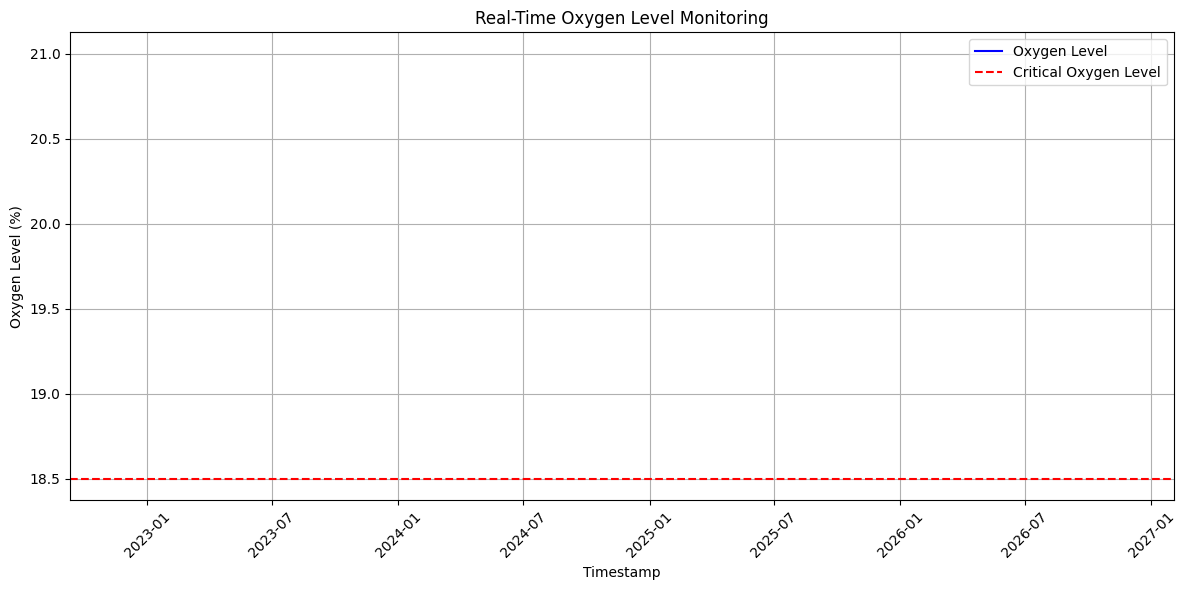

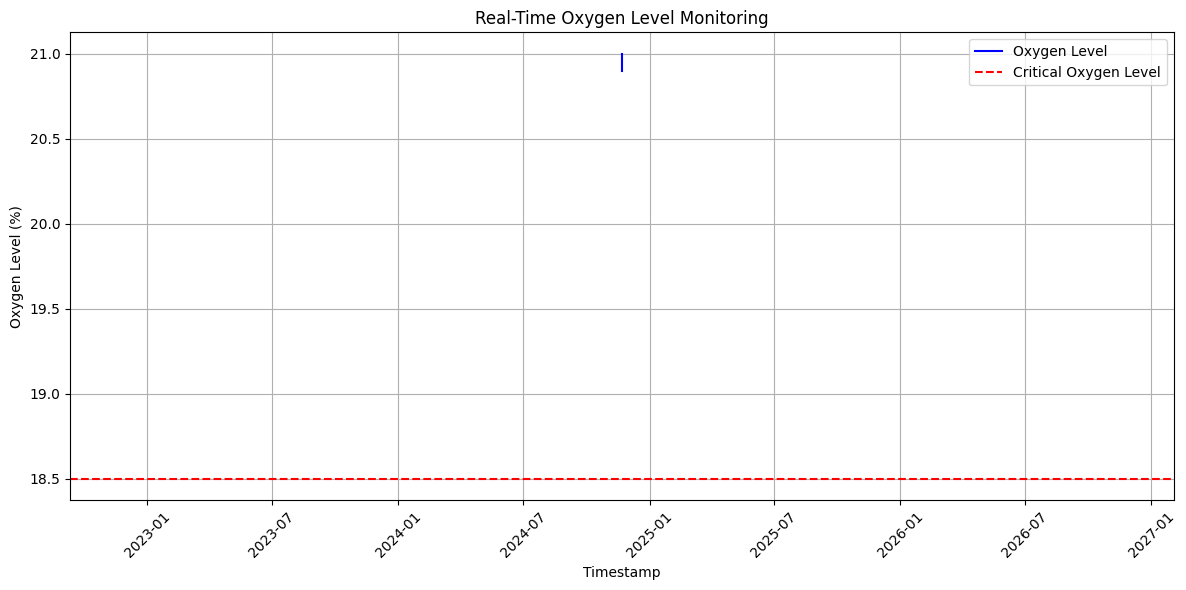

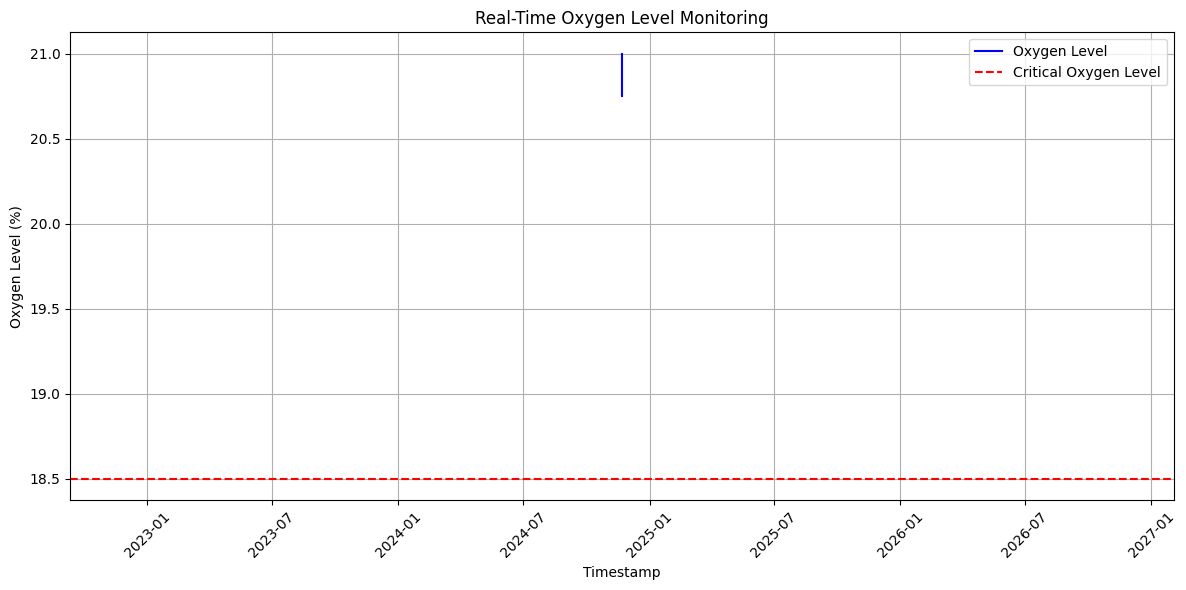

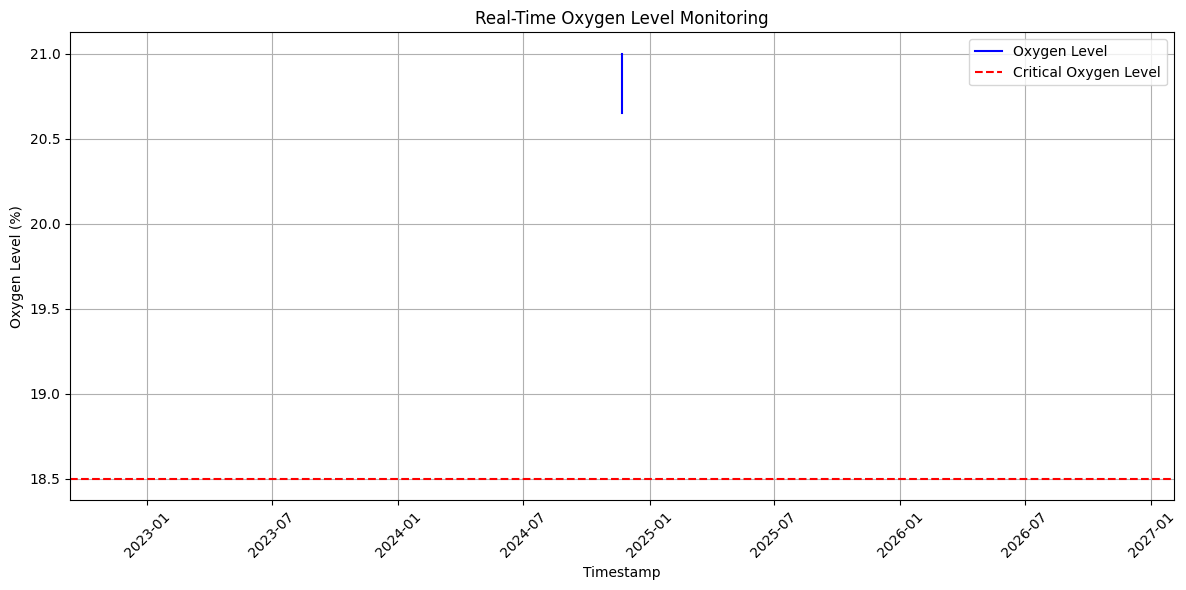

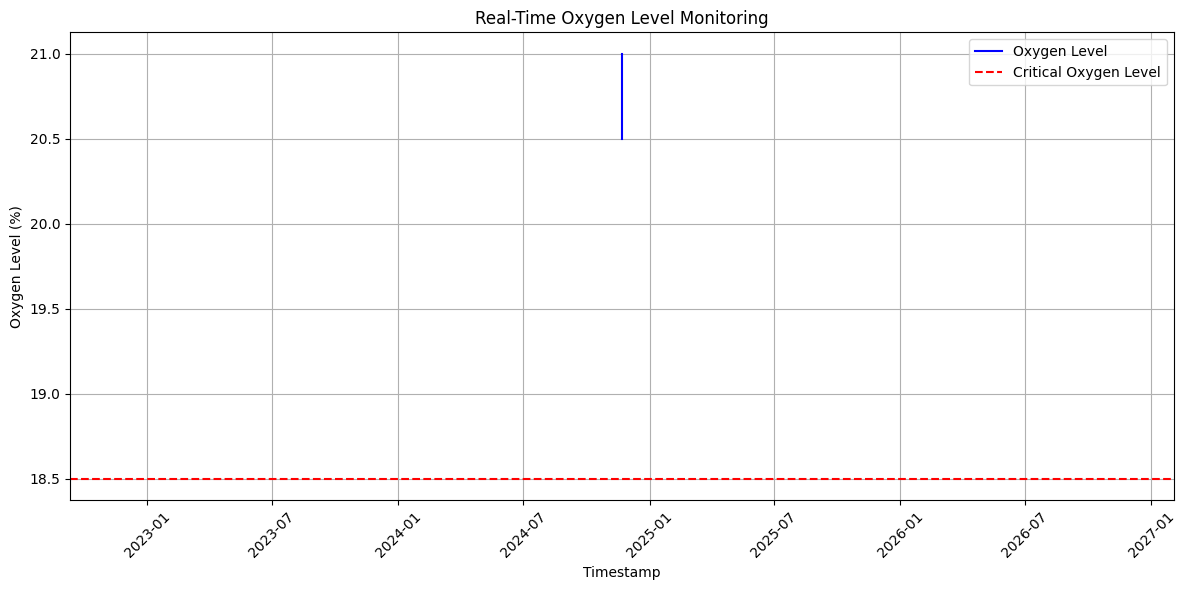

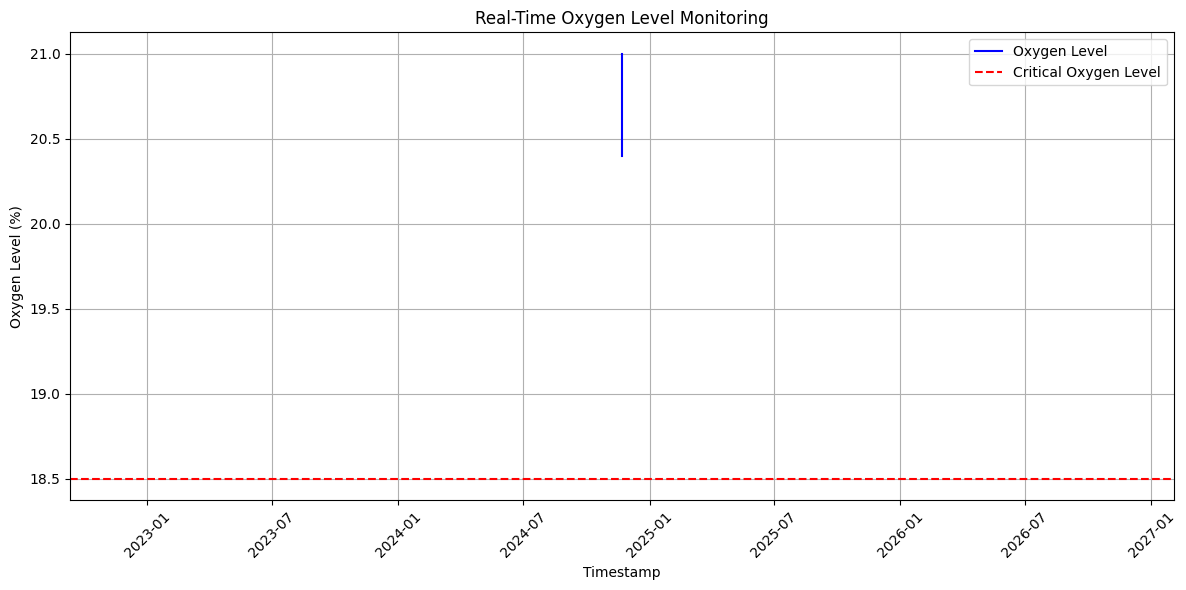

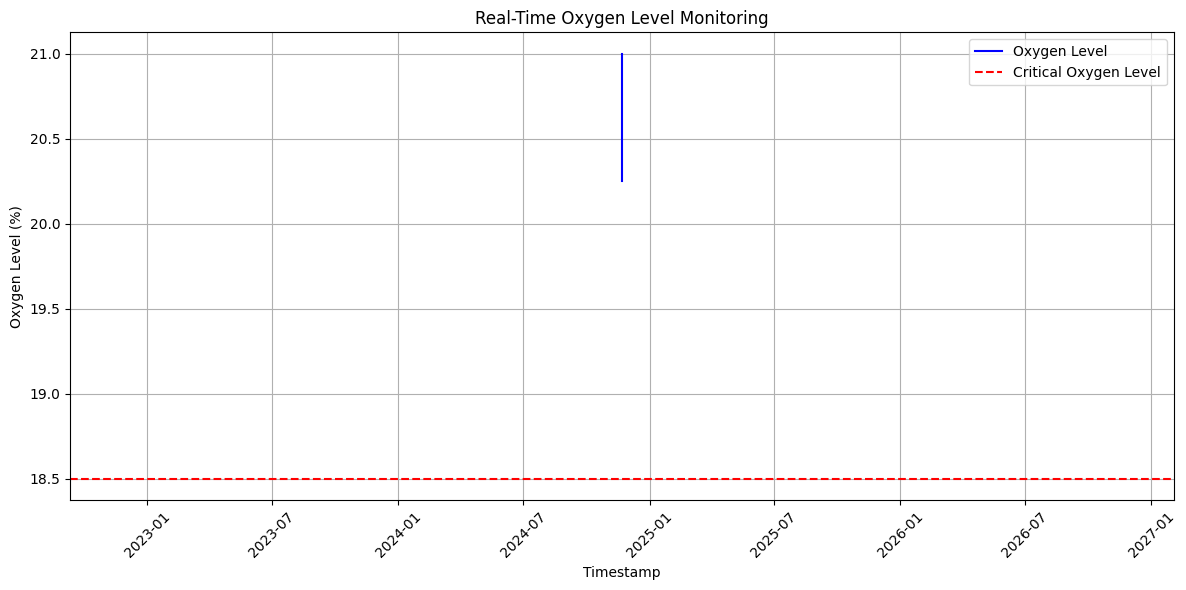

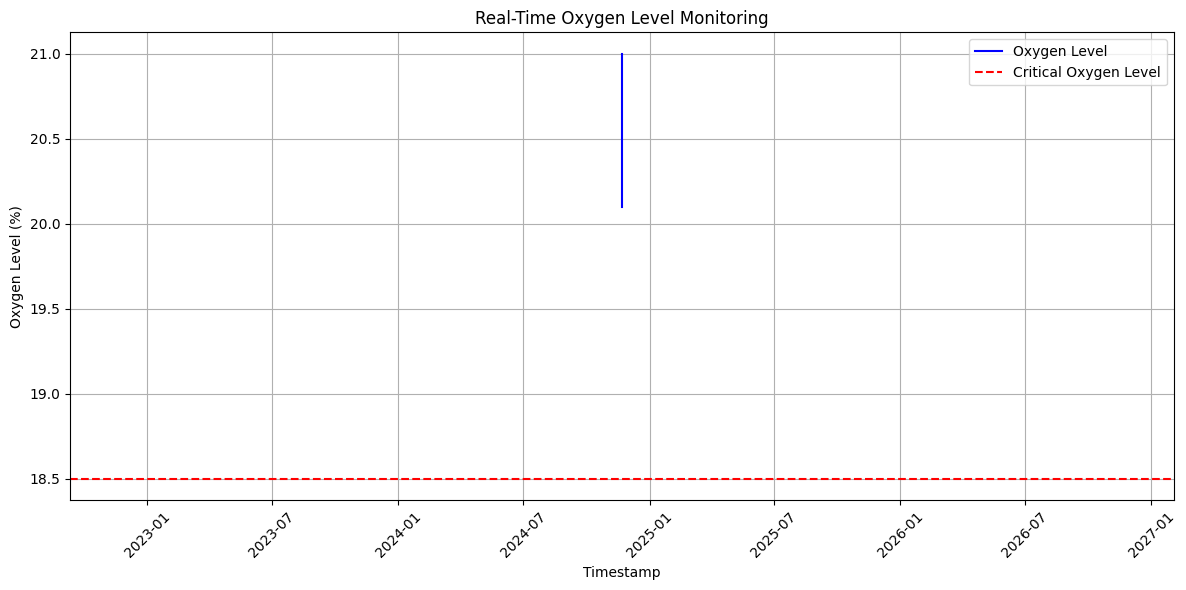

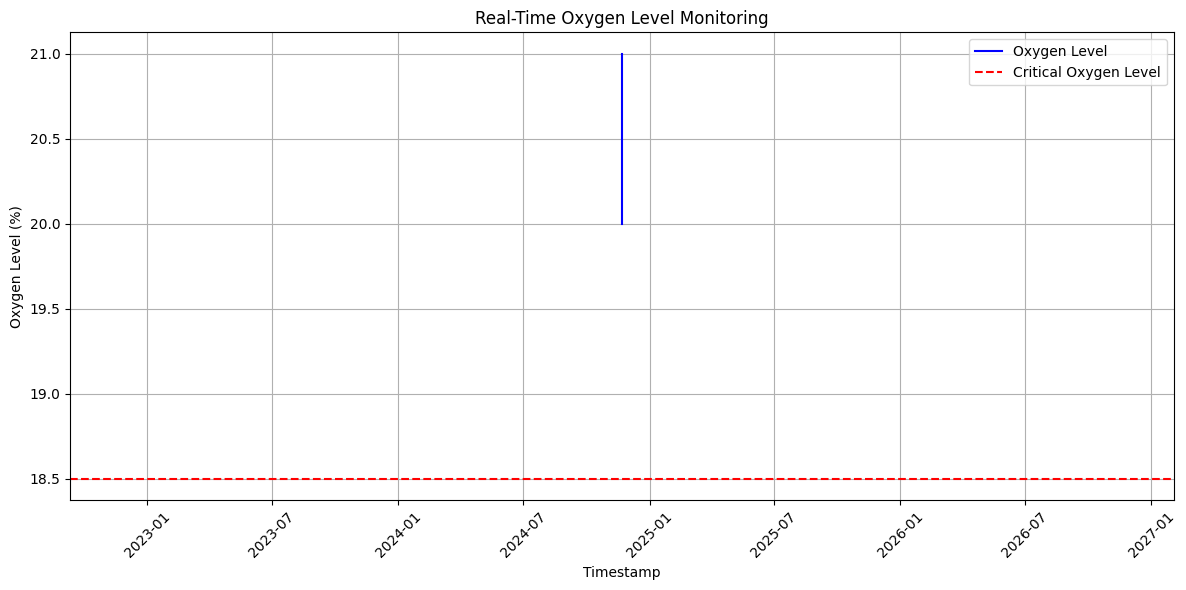

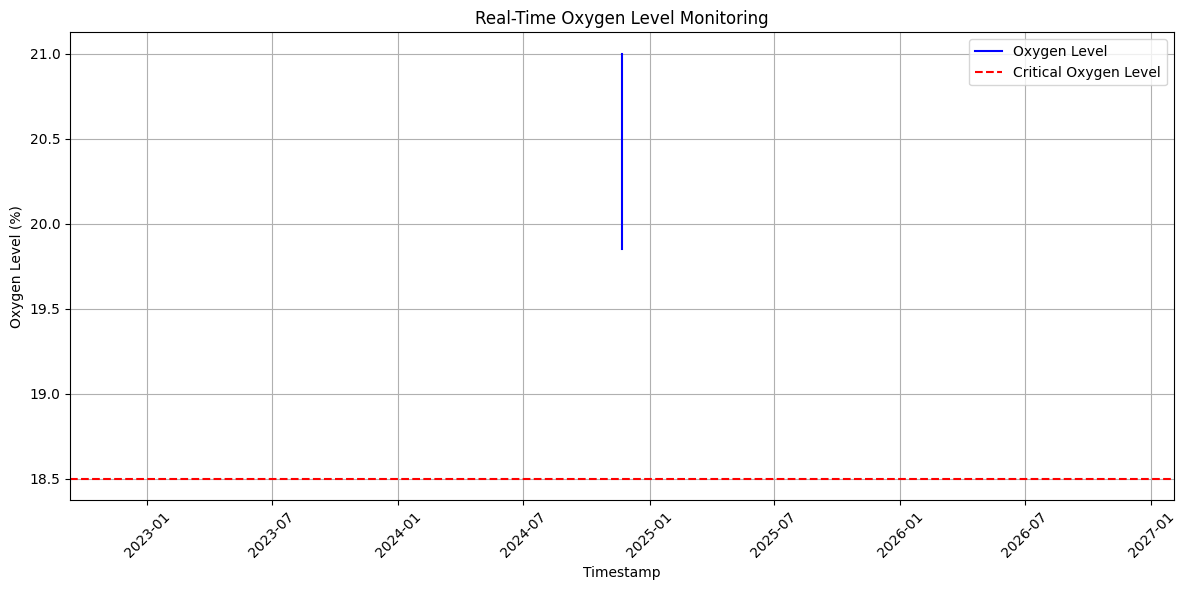

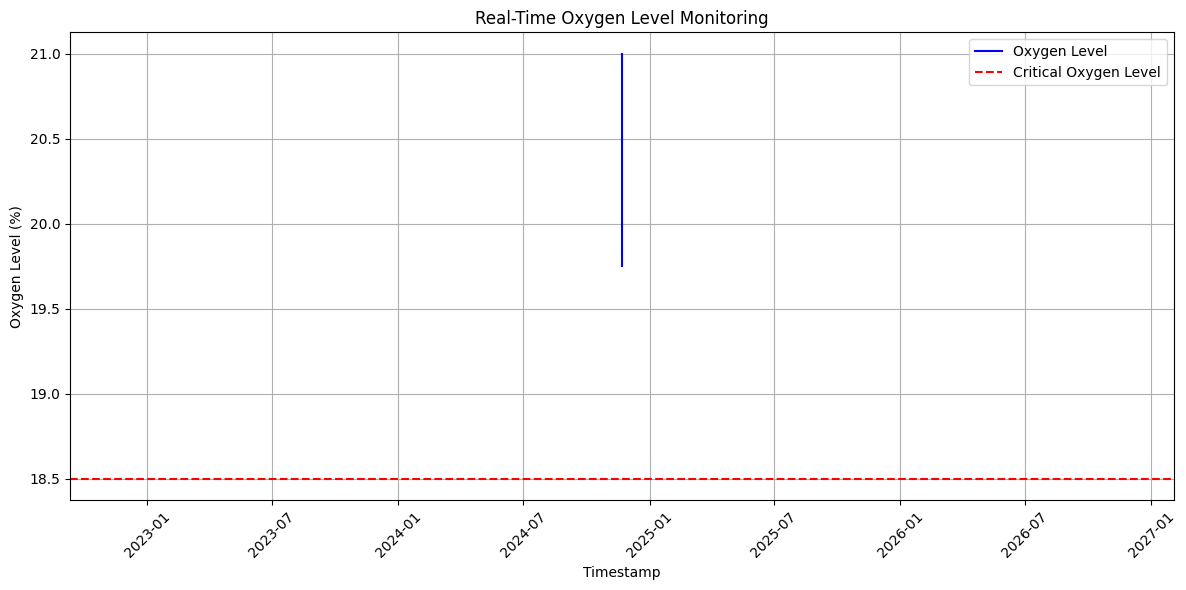

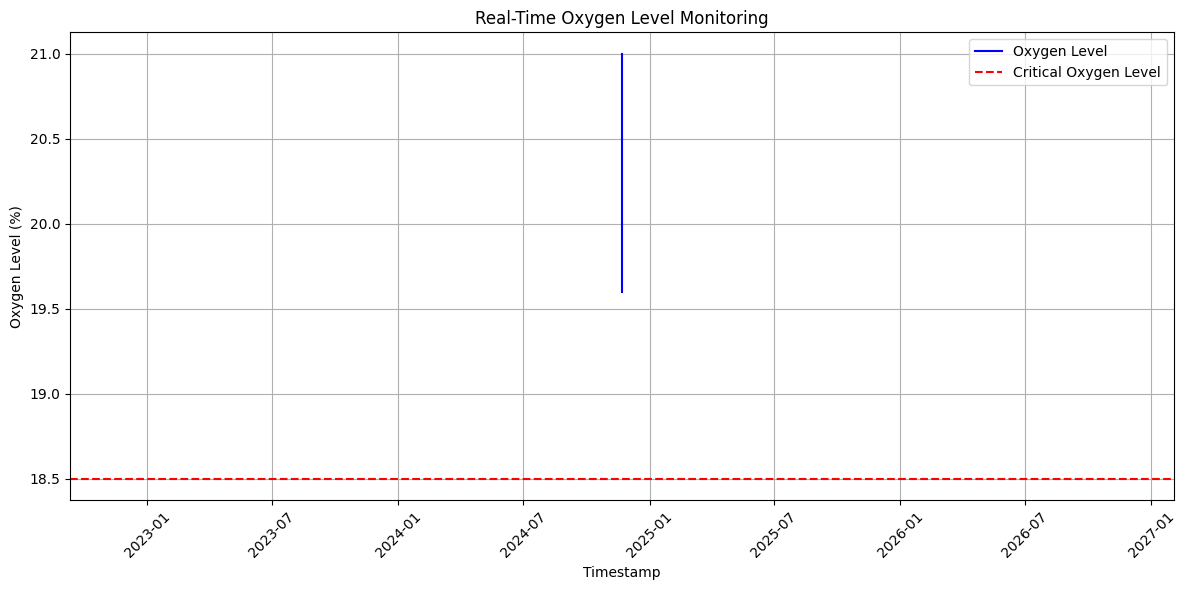

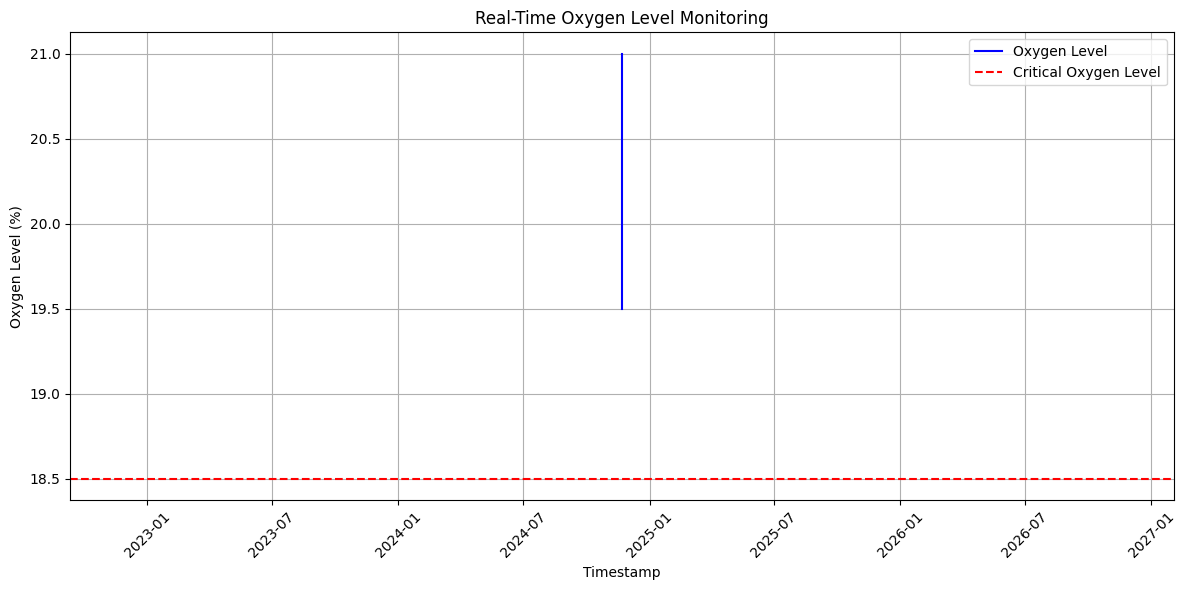

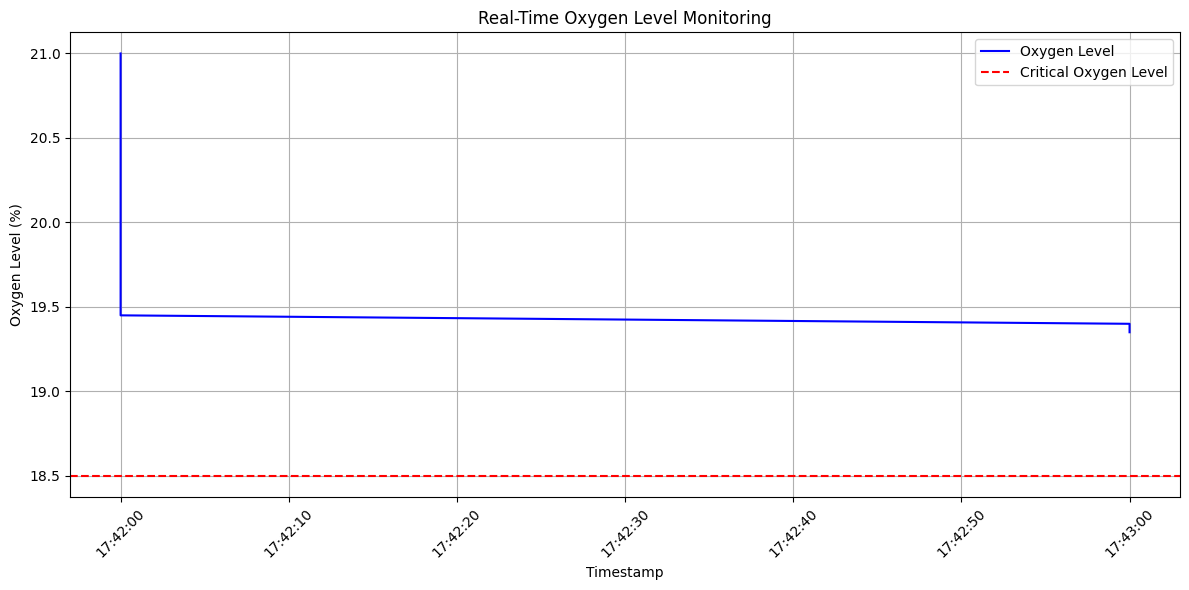

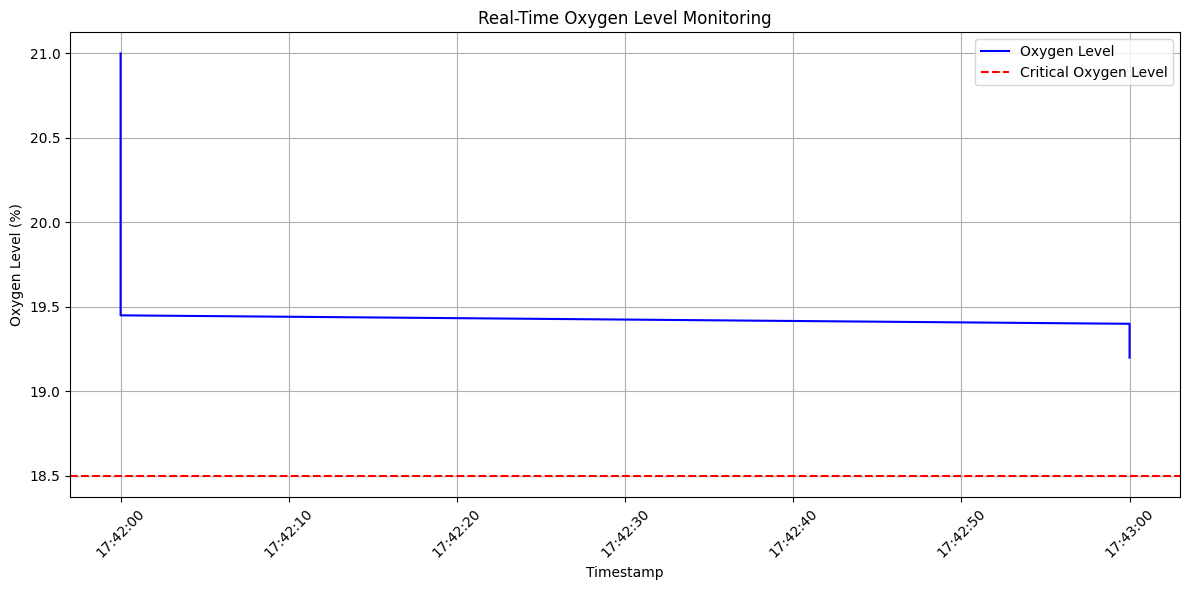

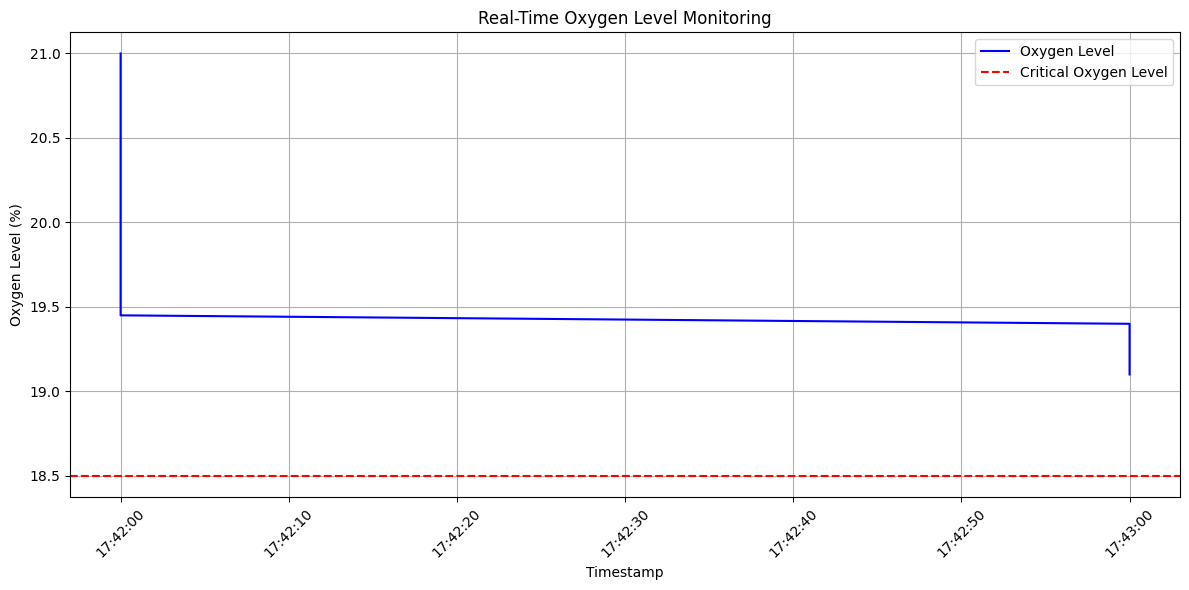

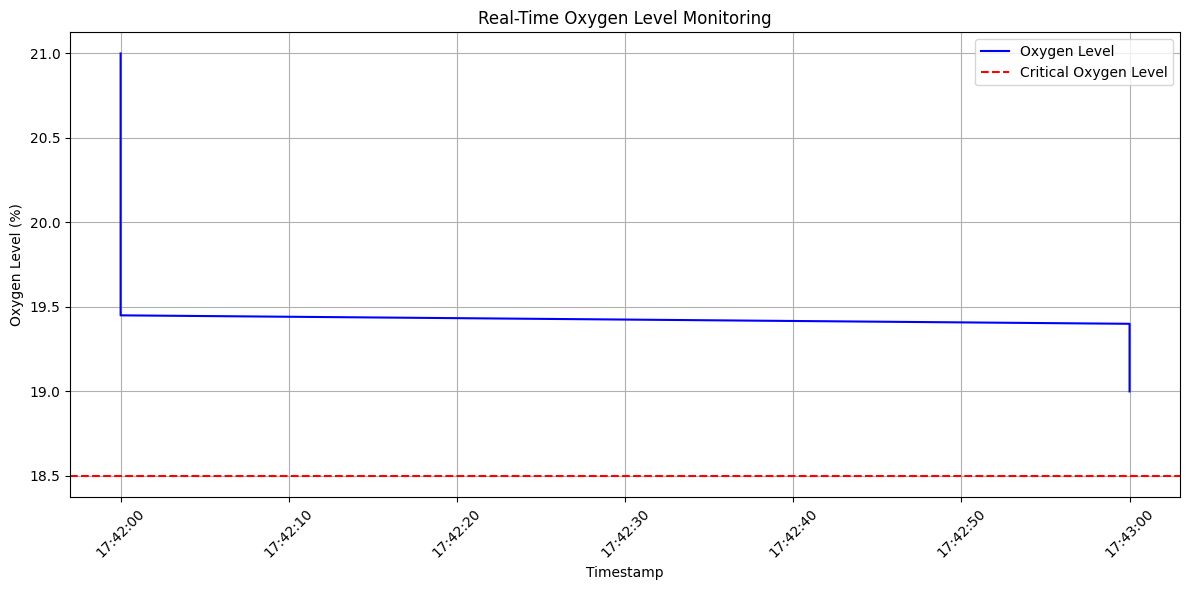

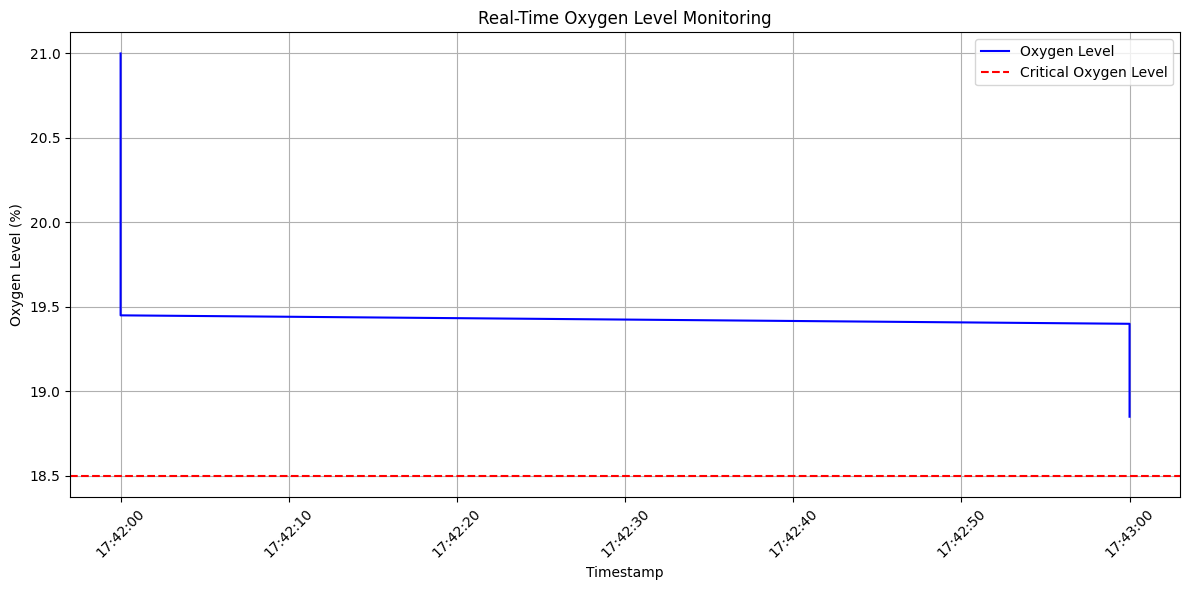

Program stopped.


In [46]:
if __name__ == "__main__":
    main()
